# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [12]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [13]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [14]:
!ls MNIST

'ls' nÆo ‚ reconhecido como um comando interno
ou externo, um programa oper vel ou um arquivo em lotes.


In [15]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [16]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

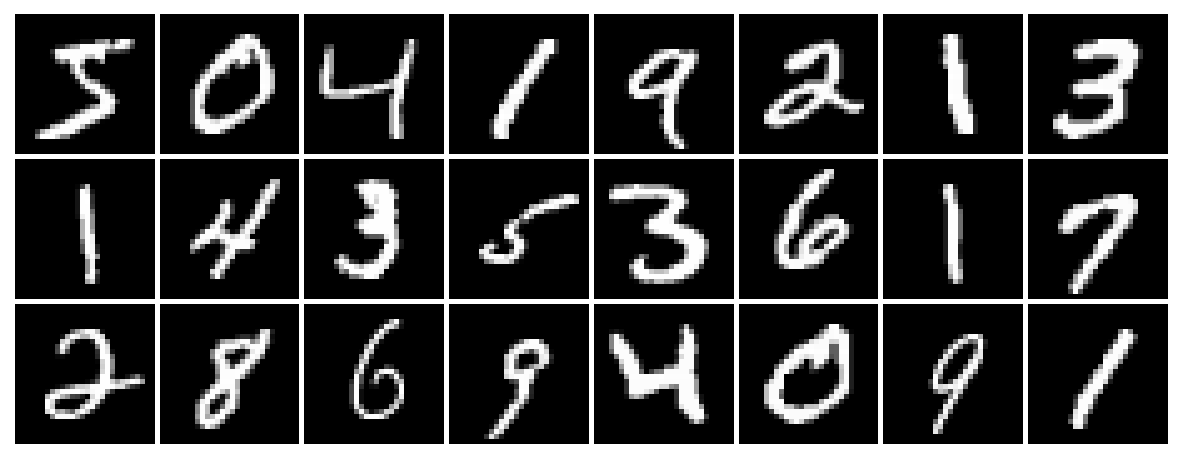

In [17]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


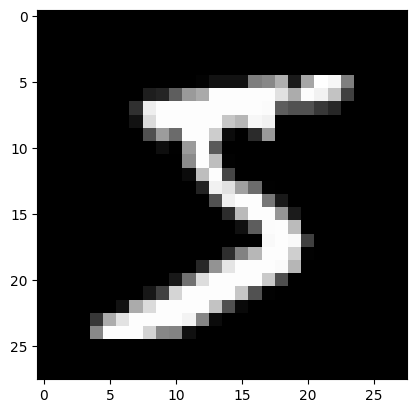

In [18]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [19]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [20]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.1490,  0.1346,  0.1319, -0.2438, -0.2982,  0.2930,  0.0456, -0.1898,
         -0.0593,  0.3429],
        [-0.1455,  0.2473,  0.1089, -0.0844, -0.4187, -0.0125, -0.0991, -0.3453,
          0.0969,  0.2867],
        [-0.1251,  0.0707, -0.2302,  0.1259,  0.0744,  0.0073,  0.1253,  0.0156,
         -0.0907,  0.0789],
        [ 0.0220, -0.1294, -0.1861,  0.1798, -0.1068,  0.0521,  0.1219, -0.4705,
         -0.0773, -0.0391],
        [-0.1368,  0.1217, -0.1214,  0.0510,  0.0808,  0.2442,  0.2156, -0.2505,
          0.0848,  0.0984]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [21]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [22]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to c:\users\mathe\appdata\local\temp\pip-req-build-s46vsrj1
  Resolved https://github.com/szagoruyko/pytorchviz to commit 5cf04c13e601366f6b9cf5939b5af5144d55b887
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz 'C:\Users\mathe\AppData\Local\Temp\pip-req-build-s46vsrj1'


In [23]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3229, grad_fn=<NllLossBackward0>)

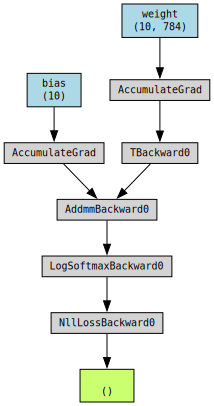

In [24]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [34]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    # Exercíco 1
    print(f"Época {i+1:3d} | Perda: {loss.item():.4f} | Acurácia: {accuracy:.4f}")

    # Exercício 2
    grad_class4 = model.weight.grad[4]
    print(f"Época {i+1:3d} | Gradiente (classe 4): {grad_class4[:5].detach().numpy()} ...")  


Época   1 | Perda: 0.1338 | Acurácia: 0.9770
Época   1 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   2 | Perda: 0.1335 | Acurácia: 0.9770
Época   2 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   3 | Perda: 0.1332 | Acurácia: 0.9770
Época   3 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   4 | Perda: 0.1328 | Acurácia: 0.9770
Época   4 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   5 | Perda: 0.1325 | Acurácia: 0.9780
Época   5 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   6 | Perda: 0.1322 | Acurácia: 0.9780
Época   6 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   7 | Perda: 0.1318 | Acurácia: 0.9780
Época   7 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   8 | Perda: 0.1315 | Acurácia: 0.9790
Época   8 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época   9 | Perda: 0.1312 | Acurácia: 0.9790
Época   9 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...
Época  10 | Perda: 0.1308 | Acurácia: 0.9790
Época  10 | Gradiente (classe 4): [0. 0. 0. 0. 0.] ...


In [26]:
print('Final loss:', loss.item())

Final loss: 0.2650236487388611


### Visualizando gráfico de perda durante o treinamento

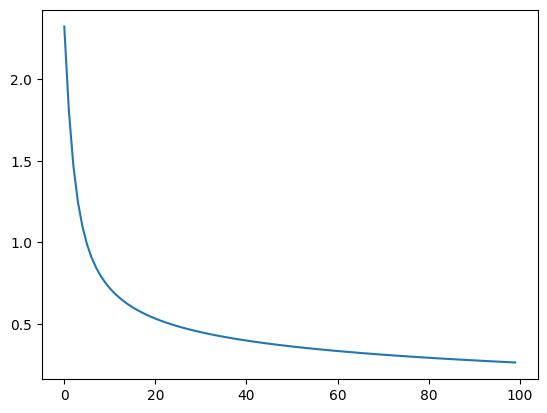

In [27]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [28]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.942


### Matriz de confusão com dados de treinamento e teste

In [29]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,111,1,0,0,0,2,3,1,0
2,0,0,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,91,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


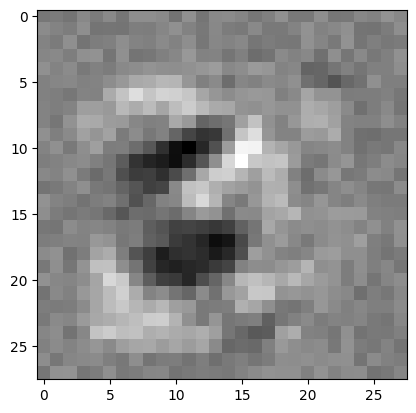

In [30]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

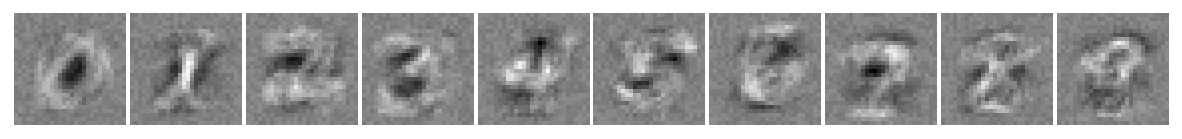

In [31]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
   - 60k de imagens do MNIST, cada imagem 28x28 pixels -> (60000, 784)
3. Qual é o shape da saída da rede?
   - São gerados 10 valores para cada imagem -> (60000, 10)
5. Qual é o número total de parâmetros da rede, incluindo o bias?
   - 784*10(pesos)+10(biases) = 7850

# Aprendizados


Neste notebook, a rede implementada foi conceitualmente semelhante à da atividade anterior, mas com um foco distinto: a classificação de imagens. O principal aprendizado foi perceber como, ao lidarmos com um problema de classificação multiclasse em um conjunto de dados visual e denso — composto por 60.000 imagens de 28×28 pixels —, a complexidade do processo aumentou consideravelmente. Isso exigiu o uso de novos recursos, como o achatamento das imagens, o uso eficiente de tensores e a adoção de estratégias para monitoramento de desempenho e visualização de pesos, mostrando como o volume e a natureza dos dados influenciam diretamente o projeto e a execução de modelos de redes neurais.